In [1]:
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dense, Dropout
import pandas as pd
from matplotlib import pyplot as plt
from sklearn.preprocessing import MinMaxScaler
import seaborn as sns

In [2]:
df=pd.read_csv("AAPL.csv",parse_dates=["Date"],index_col=[0])
print(df.index.freq)
missing_dates = pd.date_range(start=df.index.min(), end=df.index.max()).difference(df.index)
print(missing_dates)
df.shape

None
DatetimeIndex(['2022-07-02', '2022-07-03', '2022-07-04', '2022-07-09',
               '2022-07-10', '2022-07-16', '2022-07-17', '2022-07-23',
               '2022-07-24', '2022-07-30',
               ...
               '2023-05-29', '2023-06-03', '2023-06-04', '2023-06-10',
               '2023-06-11', '2023-06-17', '2023-06-18', '2023-06-19',
               '2023-06-24', '2023-06-25'],
              dtype='datetime64[ns]', length=114, freq=None)


(251, 6)

In [3]:
df.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2022-07-01,136.039993,139.039993,135.660004,138.929993,138.105347,71051600
2022-07-05,137.770004,141.610001,136.929993,141.559998,140.719742,73353800
2022-07-06,141.350006,144.119995,141.080002,142.919998,142.071655,74064300
2022-07-07,143.289993,146.550003,143.279999,146.350006,145.481308,66253700
2022-07-08,145.259995,147.550003,145.000000,147.039993,146.167191,64547800


In [4]:
df.tail()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2023-06-26,186.830002,188.050003,185.229996,185.270004,185.270004,48088700
2023-06-27,185.889999,188.389999,185.669998,188.059998,188.059998,50730800
2023-06-28,187.929993,189.899994,187.600006,189.250000,189.250000,51216800
2023-06-29,189.080002,190.070007,188.940002,189.589996,189.589996,46347300
2023-06-30,191.630005,194.479996,191.259995,193.970001,193.970001,85069600


In [5]:
def train_test_split(data, prediction_size):
    train_size = int(len(data) * (1-prediction_size))
    train = pd.DataFrame(data[0:train_size])
    test = pd.DataFrame(data[train_size:len(data)])
    return train, test
df_train, df_test = train_test_split(df, 0.2)

In [6]:
print(df_train.shape)
print(df_test.shape)

(200, 6)
(51, 6)


In [7]:
# 归一化
scaler = MinMaxScaler(feature_range=(0,1))
df_train_scaled = scaler.fit_transform(df_train)
df_test_scaled = scaler.transform(df_test)

In [8]:
df_train_scaled

array([[0.21009618, 0.23294743, 0.23472945, 0.28083978, 0.27390891,
        0.27673588],
       [0.24633436, 0.28606872, 0.26067407, 0.33393901, 0.32715747,
        0.29450437],
       [0.32132393, 0.33794955, 0.34545465, 0.36139711, 0.35469249,
        0.29998804],
       ...,
       [0.80812726, 0.79681712, 0.81001045, 0.81142752, 0.82131397,
        0.10952368],
       [0.81860066, 0.77759414, 0.81430038, 0.81183109, 0.82172047,
        0.04878036],
       [0.83975714, 0.81934703, 0.84739527, 0.83686652, 0.84694142,
        0.11366441]])

In [9]:
df_test_scaled

array([[0.83347303, 0.83484931, 0.84514806, 0.86028675, 0.8705351 ,
        0.0966631 ],
       [0.83954746, 0.82885491, 0.84555674, 0.84050054, 0.85060212,
        0.13321731],
       [0.81776294, 0.79950398, 0.82369784, 0.8075914 , 0.81744937,
        0.17860635],
       [0.81671553, 0.78193492, 0.81144032, 0.81385019, 0.82375455,
        0.05212536],
       [0.82069547, 0.79661024, 0.80817161, 0.78235418, 0.79202519,
        0.10433407],
       [0.77607871, 0.77532047, 0.78917278, 0.7821521 , 0.79182162,
        0.07951824],
       [0.82069547, 0.84311706, 0.83799809, 0.87603476, 0.88639961,
        0.22927531],
       [0.88981996, 0.86978114, 0.89295219, 0.90167556, 0.91223032,
        0.15446354],
       [0.9063678 , 0.88218277, 0.90847811, 0.89985854, 0.9103998 ,
        0.13334465],
       [0.92333464, 0.88011599, 0.88600608, 0.87865921, 0.88904345,
        0.10210818],
       [0.91097612, 0.89189755, 0.87824328, 0.85665243, 0.86687376,
        0.23107902],
       [0.81441137, 0

In [10]:
# def createXY(dataset,n_past):
#     dataX = []
#     dataY = []
#     for i in range(n_past, len(dataset)):
#             dataX.append(dataset[i - n_past:i, 0:dataset.shape[1]])
#             dataY.append(dataset[i,0])
#     return np.array(dataX),np.array(dataY)

In [11]:
def generate_time_series_data(input_data, history_length):
    X_data, Y_data = [], []

    for idx in range(history_length, len(input_data)):
        X_data.append(input_data[idx-history_length :idx, 0:input_data.shape[1]])
        Y_data.append(input_data[idx, 0]) #这里，对于每个 idx，我们只取第一个特征的值作为输出。这意味着我们正在尝试预测每个时间点的第一个特征的值

    return np.array(X_data), np.array(Y_data)

In [12]:
#假设你只想预测第1、第3和第5个特征（记住，索引是从0开始的）
#Y_data.append(input_data[idx, [0, 2, 4]])

In [13]:
df_train_scaled.shape[1] #总共6列值

6

In [14]:
trainX,trainY=generate_time_series_data(df_train_scaled,30)
testX,testY=generate_time_series_data(df_test_scaled,30)

In [15]:
print("trainX Shape-- ",trainX.shape) #trainX consists of 1984 time Windows, each consisting of 30 consecutive time steps with 6 features per time step
print("trainY Shape-- ",trainY.shape)

trainX Shape--  (170, 30, 6)
trainY Shape--  (170,)


In [16]:
print("testX Shape-- ",testX.shape)
print("testY Shape-- ",testY.shape)

testX Shape--  (21, 30, 6)
testY Shape--  (21,)


In [17]:
print("trainX[0]-- \n",trainX[0])
print("\ntrainY[0]-- ",trainY[0])

trainX[0]-- 
 [[0.21009618 0.23294743 0.23472945 0.28083978 0.27390891 0.27673588]
 [0.24633436 0.28606872 0.26067407 0.33393901 0.32715747 0.29450437]
 [0.32132393 0.33794955 0.34545465 0.36139711 0.35469249 0.29998804]
 [0.36196045 0.38817708 0.39039841 0.43064822 0.42413843 0.23970548]
 [0.40322568 0.40884678 0.42553633 0.44457891 0.43810811 0.22653927]
 [0.41181393 0.39003727 0.40061292 0.40076712 0.39417339 0.21568615]
 [0.41369907 0.42744939 0.42655784 0.42075513 0.41421732 0.32719028]
 [0.35567666 0.38610999 0.36670068 0.41328499 0.40672621 0.2777701 ]
 [0.3785086  0.43778424 0.38978556 0.47345046 0.46706093 0.33144987]
 [0.49790528 0.47726344 0.4909091  0.50777303 0.50147979 0.31693378]
 [0.51801433 0.49193905 0.46026558 0.44518488 0.438716   0.3567666 ]
 [0.45894422 0.48491113 0.46455582 0.52453058 0.51828442 0.36881833]
 [0.5259739  0.53637878 0.53524001 0.5657176  0.55958745 0.22866636]
 [0.59677418 0.57461785 0.5673137  0.61235626 0.60635713 0.23069775]
 [0.6154168  0.58929

In [18]:
from keras.wrappers.scikit_learn import KerasRegressor
from sklearn.model_selection import GridSearchCV

In [19]:
def build_model(optimizer):
    grid_model = Sequential()
    grid_model.add(LSTM(50,return_sequences=True,input_shape=(30,6)))
    grid_model.add(LSTM(50))
    grid_model.add(Dropout(0.2))
    grid_model.add(Dense(1))

    grid_model.compile(loss = 'mse',optimizer = optimizer)
    return grid_model

grid_model = KerasRegressor(build_fn=build_model,verbose=1,validation_data=(testX,testY))
parameters = {'batch_size' : [ 32, 64], # , 128, 256, 512
              'epochs' : [ 50, 100], # , 200
              'optimizer' : ['adam','Adadelta'] }

grid_search  = GridSearchCV(estimator = grid_model,
                            param_grid = parameters,
                            cv = 2)

C:\Users\eq220\AppData\Local\Temp\ipykernel_19948\3563693491.py:11: DeprecationWarning: KerasRegressor is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  grid_model = KerasRegressor(build_fn=build_model,verbose=1,validation_data=(testX,testY))


In [20]:
import numpy as np
from skopt import gp_minimize
from skopt.space import Real, Integer
from skopt.utils import use_named_args
from tensorflow.keras.optimizers import Adam


# 定义超参数空间
space  = [Integer(32, 256, name='lstm_neurons'),
          Real(0.1, 0.9, name='dropout_rate'),
          Real(1e-4, 1e-2, name='learning_rate', prior='log-uniform')]

# 定义优化目标函数
@use_named_args(space)
def objective(**params):
    # 在这里构建您的 LSTM 模型
    model = Sequential()
    model.add(LSTM(params['lstm_neurons'], input_shape=(trainX.shape[1], trainX.shape[2])))
    model.add(Dropout(params['dropout_rate']))
    model.add(Dense(1))
    
    optimizer = Adam(learning_rate=params['learning_rate'])
    model.compile(optimizer=optimizer, loss='mse')
    
    history = model.fit(trainX, trainY, epochs=50, batch_size=32, validation_data=(testX, testY), verbose=0, shuffle=False)
    
    # 返回验证损失
    return history.history['val_loss'][-1]

# 执行贝叶斯优化
res = gp_minimize(objective, space, n_calls=50, random_state=0)

# 输出最佳参数
print("Best parameters: {}".format(res.x))


Best parameters: [85, 0.1, 0.008930903019374672]


In [21]:
grid_search = grid_search.fit(trainX,trainY)

Epoch 1/50
3/3 [==============================] - 2s 217ms/step - loss: 0.0905 - val_loss: 0.1143
Epoch 2/50
3/3 [==============================] - 0s 22ms/step - loss: 0.0454 - val_loss: 0.0233
Epoch 3/50
3/3 [==============================] - 0s 24ms/step - loss: 0.0369 - val_loss: 0.1237
Epoch 4/50
3/3 [==============================] - 0s 24ms/step - loss: 0.0204 - val_loss: 0.2109
Epoch 5/50
3/3 [==============================] - 0s 22ms/step - loss: 0.0349 - val_loss: 0.1894
Epoch 6/50
3/3 [==============================] - 0s 22ms/step - loss: 0.0210 - val_loss: 0.1090
Epoch 7/50
3/3 [==============================] - 0s 22ms/step - loss: 0.0146 - val_loss: 0.0351
Epoch 8/50
3/3 [==============================] - 0s 24ms/step - loss: 0.0144 - val_loss: 0.0101
Epoch 9/50
3/3 [==============================] - 0s 24ms/step - loss: 0.0152 - val_loss: 0.0144
Epoch 10/50
3/3 [==============================] - 0s 24ms/step - loss: 0.0136 - val_loss: 0.0400
Epoch 11/50
3/3 [===========

3/3 [==============================] - 0s 22ms/step - loss: 0.0125 - val_loss: 0.0216
Epoch 35/50
3/3 [==============================] - 0s 22ms/step - loss: 0.0113 - val_loss: 0.0543
Epoch 36/50
3/3 [==============================] - 0s 22ms/step - loss: 0.0107 - val_loss: 0.0665
Epoch 37/50
3/3 [==============================] - 0s 22ms/step - loss: 0.0110 - val_loss: 0.0372
Epoch 38/50
3/3 [==============================] - 0s 20ms/step - loss: 0.0127 - val_loss: 0.0237
Epoch 39/50
3/3 [==============================] - 0s 22ms/step - loss: 0.0132 - val_loss: 0.0461
Epoch 40/50
3/3 [==============================] - 0s 22ms/step - loss: 0.0101 - val_loss: 0.0488
Epoch 41/50
3/3 [==============================] - 0s 21ms/step - loss: 0.0102 - val_loss: 0.0341
Epoch 42/50
3/3 [==============================] - 0s 22ms/step - loss: 0.0118 - val_loss: 0.0276
Epoch 43/50
3/3 [==============================] - 0s 22ms/step - loss: 0.0104 - val_loss: 0.0310
Epoch 44/50
3/3 [===============

3/3 [==============================] - 0s 21ms/step - loss: 0.3248 - val_loss: 1.5310
Epoch 17/50
3/3 [==============================] - 0s 21ms/step - loss: 0.3198 - val_loss: 1.5291
Epoch 18/50
3/3 [==============================] - 0s 20ms/step - loss: 0.3270 - val_loss: 1.5272
Epoch 19/50
3/3 [==============================] - 0s 22ms/step - loss: 0.3104 - val_loss: 1.5254
Epoch 20/50
3/3 [==============================] - 0s 24ms/step - loss: 0.3106 - val_loss: 1.5235
Epoch 21/50
3/3 [==============================] - 0s 23ms/step - loss: 0.3154 - val_loss: 1.5217
Epoch 22/50
3/3 [==============================] - 0s 22ms/step - loss: 0.3161 - val_loss: 1.5198
Epoch 23/50
3/3 [==============================] - 0s 23ms/step - loss: 0.3148 - val_loss: 1.5179
Epoch 24/50
3/3 [==============================] - 0s 23ms/step - loss: 0.3121 - val_loss: 1.5161
Epoch 25/50
3/3 [==============================] - 0s 21ms/step - loss: 0.3169 - val_loss: 1.5142
Epoch 26/50
3/3 [===============

3/3 [==============================] - 0s 23ms/step - loss: 0.0053 - val_loss: 0.0058
Epoch 49/100
3/3 [==============================] - 0s 24ms/step - loss: 0.0075 - val_loss: 0.0079
Epoch 50/100
3/3 [==============================] - 0s 25ms/step - loss: 0.0062 - val_loss: 0.0044
Epoch 51/100
3/3 [==============================] - 0s 23ms/step - loss: 0.0045 - val_loss: 0.0065
Epoch 52/100
3/3 [==============================] - 0s 24ms/step - loss: 0.0048 - val_loss: 0.0113
Epoch 53/100
3/3 [==============================] - 0s 23ms/step - loss: 0.0048 - val_loss: 0.0101
Epoch 54/100
3/3 [==============================] - 0s 23ms/step - loss: 0.0059 - val_loss: 0.0074
Epoch 55/100
3/3 [==============================] - 0s 23ms/step - loss: 0.0060 - val_loss: 0.0084
Epoch 56/100
3/3 [==============================] - 0s 24ms/step - loss: 0.0054 - val_loss: 0.0049
Epoch 57/100
3/3 [==============================] - 0s 25ms/step - loss: 0.0045 - val_loss: 0.0058
Epoch 58/100
3/3 [=====

3/3 [==============================] - 0s 21ms/step - loss: 0.0131 - val_loss: 0.0267
Epoch 31/100
3/3 [==============================] - 0s 20ms/step - loss: 0.0120 - val_loss: 0.0279
Epoch 32/100
3/3 [==============================] - 0s 22ms/step - loss: 0.0120 - val_loss: 0.0334
Epoch 33/100
3/3 [==============================] - 0s 23ms/step - loss: 0.0120 - val_loss: 0.0353
Epoch 34/100
3/3 [==============================] - 0s 23ms/step - loss: 0.0106 - val_loss: 0.0325
Epoch 35/100
3/3 [==============================] - 0s 23ms/step - loss: 0.0118 - val_loss: 0.0297
Epoch 36/100
3/3 [==============================] - 0s 24ms/step - loss: 0.0111 - val_loss: 0.0358
Epoch 37/100
3/3 [==============================] - 0s 22ms/step - loss: 0.0113 - val_loss: 0.0340
Epoch 38/100
3/3 [==============================] - 0s 21ms/step - loss: 0.0097 - val_loss: 0.0306
Epoch 39/100
3/3 [==============================] - 0s 21ms/step - loss: 0.0095 - val_loss: 0.0232
Epoch 40/100
3/3 [=====

3/3 [==============================] - 0s 23ms/step - loss: 0.0843 - val_loss: 0.6374
Epoch 13/100
3/3 [==============================] - 0s 23ms/step - loss: 0.0865 - val_loss: 0.6364
Epoch 14/100
3/3 [==============================] - 0s 25ms/step - loss: 0.0859 - val_loss: 0.6353
Epoch 15/100
3/3 [==============================] - 0s 23ms/step - loss: 0.0834 - val_loss: 0.6342
Epoch 16/100
3/3 [==============================] - 0s 24ms/step - loss: 0.0786 - val_loss: 0.6331
Epoch 17/100
3/3 [==============================] - 0s 25ms/step - loss: 0.0910 - val_loss: 0.6320
Epoch 18/100
3/3 [==============================] - 0s 23ms/step - loss: 0.0878 - val_loss: 0.6309
Epoch 19/100
3/3 [==============================] - 0s 22ms/step - loss: 0.0822 - val_loss: 0.6298
Epoch 20/100
3/3 [==============================] - 0s 22ms/step - loss: 0.0812 - val_loss: 0.6287
Epoch 21/100
3/3 [==============================] - 0s 22ms/step - loss: 0.0874 - val_loss: 0.6276
Epoch 22/100
3/3 [=====

Epoch 95/100
3/3 [==============================] - 0s 23ms/step - loss: 0.0736 - val_loss: 0.5461
Epoch 96/100
3/3 [==============================] - 0s 22ms/step - loss: 0.0620 - val_loss: 0.5451
Epoch 97/100
3/3 [==============================] - 0s 25ms/step - loss: 0.0653 - val_loss: 0.5440
Epoch 98/100
3/3 [==============================] - 0s 23ms/step - loss: 0.0678 - val_loss: 0.5429
Epoch 99/100
3/3 [==============================] - 0s 24ms/step - loss: 0.0656 - val_loss: 0.5418
Epoch 100/100
3/3 [==============================] - 0s 6ms/step - loss: 0.0643
Epoch 1/100
3/3 [==============================] - 2s 215ms/step - loss: 0.2953 - val_loss: 1.3365
Epoch 2/100
3/3 [==============================] - 0s 21ms/step - loss: 0.2970 - val_loss: 1.3345
Epoch 3/100
3/3 [==============================] - 0s 22ms/step - loss: 0.2886 - val_loss: 1.3325
Epoch 4/100
3/3 [==============================] - 0s 23ms/step - loss: 0.3102 - val_loss: 1.3305
Epoch 5/100
3/3 [===============

3/3 [==============================] - 0s 20ms/step - loss: 0.2527 - val_loss: 1.1784
Epoch 78/100
3/3 [==============================] - 0s 22ms/step - loss: 0.2575 - val_loss: 1.1763
Epoch 79/100
3/3 [==============================] - 0s 22ms/step - loss: 0.2500 - val_loss: 1.1741
Epoch 80/100
3/3 [==============================] - 0s 22ms/step - loss: 0.2440 - val_loss: 1.1720
Epoch 81/100
3/3 [==============================] - 0s 20ms/step - loss: 0.2481 - val_loss: 1.1699
Epoch 82/100
3/3 [==============================] - 0s 22ms/step - loss: 0.2619 - val_loss: 1.1678
Epoch 83/100
3/3 [==============================] - 0s 22ms/step - loss: 0.2456 - val_loss: 1.1657
Epoch 84/100
3/3 [==============================] - 0s 22ms/step - loss: 0.2295 - val_loss: 1.1637
Epoch 85/100
3/3 [==============================] - 0s 22ms/step - loss: 0.2399 - val_loss: 1.1616
Epoch 86/100
3/3 [==============================] - 0s 22ms/step - loss: 0.2321 - val_loss: 1.1596
Epoch 87/100
3/3 [=====

2/2 [==============================] - 0s 34ms/step - loss: 0.0241 - val_loss: 0.1463
Epoch 10/50
2/2 [==============================] - 0s 39ms/step - loss: 0.0204 - val_loss: 0.0974
Epoch 11/50
2/2 [==============================] - 0s 38ms/step - loss: 0.0159 - val_loss: 0.0593
Epoch 12/50
2/2 [==============================] - 0s 34ms/step - loss: 0.0195 - val_loss: 0.0416
Epoch 13/50
2/2 [==============================] - 0s 33ms/step - loss: 0.0172 - val_loss: 0.0424
Epoch 14/50
2/2 [==============================] - 0s 33ms/step - loss: 0.0176 - val_loss: 0.0511
Epoch 15/50
2/2 [==============================] - 0s 32ms/step - loss: 0.0191 - val_loss: 0.0593
Epoch 16/50
2/2 [==============================] - 0s 35ms/step - loss: 0.0186 - val_loss: 0.0652
Epoch 17/50
2/2 [==============================] - 0s 32ms/step - loss: 0.0192 - val_loss: 0.0685
Epoch 18/50
2/2 [==============================] - 0s 37ms/step - loss: 0.0160 - val_loss: 0.0691
Epoch 19/50
2/2 [===============

2/2 [==============================] - 0s 32ms/step - loss: 0.2035 - val_loss: 1.2331
Epoch 43/50
2/2 [==============================] - 0s 33ms/step - loss: 0.2150 - val_loss: 1.2317
Epoch 44/50
2/2 [==============================] - 0s 32ms/step - loss: 0.2168 - val_loss: 1.2304
Epoch 45/50
2/2 [==============================] - 0s 32ms/step - loss: 0.2063 - val_loss: 1.2291
Epoch 46/50
2/2 [==============================] - 0s 28ms/step - loss: 0.2101 - val_loss: 1.2276
Epoch 47/50
2/2 [==============================] - 0s 28ms/step - loss: 0.2075 - val_loss: 1.2262
Epoch 48/50
2/2 [==============================] - 0s 32ms/step - loss: 0.2010 - val_loss: 1.2247
Epoch 49/50
2/2 [==============================] - 0s 32ms/step - loss: 0.2041 - val_loss: 1.2233
Epoch 50/50
2/2 [==============================] - 0s 4ms/step - loss: 0.2447
Epoch 1/50
2/2 [==============================] - 2s 416ms/step - loss: 0.1523 - val_loss: 0.8548
Epoch 2/50
2/2 [==============================] - 0s

2/2 [==============================] - 0s 33ms/step - loss: 0.0128 - val_loss: 0.0438
Epoch 25/100
2/2 [==============================] - 0s 34ms/step - loss: 0.0121 - val_loss: 0.0337
Epoch 26/100
2/2 [==============================] - 0s 35ms/step - loss: 0.0102 - val_loss: 0.0253
Epoch 27/100
2/2 [==============================] - 0s 34ms/step - loss: 0.0110 - val_loss: 0.0200
Epoch 28/100
2/2 [==============================] - 0s 34ms/step - loss: 0.0099 - val_loss: 0.0186
Epoch 29/100
2/2 [==============================] - 0s 33ms/step - loss: 0.0102 - val_loss: 0.0224
Epoch 30/100
2/2 [==============================] - 0s 33ms/step - loss: 0.0096 - val_loss: 0.0301
Epoch 31/100
2/2 [==============================] - 0s 34ms/step - loss: 0.0106 - val_loss: 0.0386
Epoch 32/100
2/2 [==============================] - 0s 33ms/step - loss: 0.0096 - val_loss: 0.0382
Epoch 33/100
2/2 [==============================] - 0s 34ms/step - loss: 0.0102 - val_loss: 0.0306
Epoch 34/100
2/2 [=====

2/2 [==============================] - 0s 32ms/step - loss: 0.0312 - val_loss: 0.3044
Epoch 7/100
2/2 [==============================] - 0s 36ms/step - loss: 0.0316 - val_loss: 0.2724
Epoch 8/100
2/2 [==============================] - 0s 32ms/step - loss: 0.0293 - val_loss: 0.2122
Epoch 9/100
2/2 [==============================] - 0s 36ms/step - loss: 0.0197 - val_loss: 0.1531
Epoch 10/100
2/2 [==============================] - 0s 33ms/step - loss: 0.0197 - val_loss: 0.1043
Epoch 11/100
2/2 [==============================] - 0s 37ms/step - loss: 0.0201 - val_loss: 0.0789
Epoch 12/100
2/2 [==============================] - 0s 32ms/step - loss: 0.0217 - val_loss: 0.0738
Epoch 13/100
2/2 [==============================] - 0s 33ms/step - loss: 0.0187 - val_loss: 0.0833
Epoch 14/100
2/2 [==============================] - 0s 32ms/step - loss: 0.0149 - val_loss: 0.0958
Epoch 15/100
2/2 [==============================] - 0s 33ms/step - loss: 0.0172 - val_loss: 0.0976
Epoch 16/100
2/2 [========

Epoch 89/100
2/2 [==============================] - 0s 32ms/step - loss: 0.0088 - val_loss: 0.0094
Epoch 90/100
2/2 [==============================] - 0s 32ms/step - loss: 0.0083 - val_loss: 0.0119
Epoch 91/100
2/2 [==============================] - 0s 36ms/step - loss: 0.0085 - val_loss: 0.0232
Epoch 92/100
2/2 [==============================] - 0s 32ms/step - loss: 0.0101 - val_loss: 0.0183
Epoch 93/100
2/2 [==============================] - 0s 33ms/step - loss: 0.0079 - val_loss: 0.0119
Epoch 94/100
2/2 [==============================] - 0s 32ms/step - loss: 0.0080 - val_loss: 0.0122
Epoch 95/100
2/2 [==============================] - 0s 32ms/step - loss: 0.0074 - val_loss: 0.0173
Epoch 96/100
2/2 [==============================] - 0s 32ms/step - loss: 0.0081 - val_loss: 0.0182
Epoch 97/100
2/2 [==============================] - 0s 32ms/step - loss: 0.0082 - val_loss: 0.0089
Epoch 98/100
2/2 [==============================] - 0s 37ms/step - loss: 0.0095 - val_loss: 0.0064
Epoch 99/1

2/2 [==============================] - 0s 35ms/step - loss: 0.1948 - val_loss: 1.0462
Epoch 72/100
2/2 [==============================] - 0s 34ms/step - loss: 0.1905 - val_loss: 1.0452
Epoch 73/100
2/2 [==============================] - 0s 33ms/step - loss: 0.1887 - val_loss: 1.0442
Epoch 74/100
2/2 [==============================] - 0s 34ms/step - loss: 0.1946 - val_loss: 1.0431
Epoch 75/100
2/2 [==============================] - 0s 32ms/step - loss: 0.1787 - val_loss: 1.0422
Epoch 76/100
2/2 [==============================] - 0s 32ms/step - loss: 0.1917 - val_loss: 1.0413
Epoch 77/100
2/2 [==============================] - 0s 32ms/step - loss: 0.1877 - val_loss: 1.0403
Epoch 78/100
2/2 [==============================] - 0s 34ms/step - loss: 0.1872 - val_loss: 1.0393
Epoch 79/100
2/2 [==============================] - 0s 34ms/step - loss: 0.1832 - val_loss: 1.0383
Epoch 80/100
2/2 [==============================] - 0s 34ms/step - loss: 0.1794 - val_loss: 1.0374
Epoch 81/100
2/2 [=====

2/2 [==============================] - 0s 32ms/step - loss: 0.3524 - val_loss: 1.6210
Epoch 54/100
2/2 [==============================] - 0s 36ms/step - loss: 0.3447 - val_loss: 1.6196
Epoch 55/100
2/2 [==============================] - 0s 32ms/step - loss: 0.3464 - val_loss: 1.6182
Epoch 56/100
2/2 [==============================] - 0s 36ms/step - loss: 0.3444 - val_loss: 1.6166
Epoch 57/100
2/2 [==============================] - 0s 36ms/step - loss: 0.3417 - val_loss: 1.6152
Epoch 58/100
2/2 [==============================] - 0s 32ms/step - loss: 0.3433 - val_loss: 1.6138
Epoch 59/100
2/2 [==============================] - 0s 36ms/step - loss: 0.3484 - val_loss: 1.6123
Epoch 60/100
2/2 [==============================] - 0s 34ms/step - loss: 0.3564 - val_loss: 1.6108
Epoch 61/100
2/2 [==============================] - 0s 37ms/step - loss: 0.3429 - val_loss: 1.6094
Epoch 62/100
2/2 [==============================] - 0s 36ms/step - loss: 0.3437 - val_loss: 1.6079
Epoch 63/100
2/2 [=====

6/6 [==============================] - 0s 15ms/step - loss: 0.0083 - val_loss: 0.0078
Epoch 36/100
6/6 [==============================] - 0s 15ms/step - loss: 0.0077 - val_loss: 0.0077
Epoch 37/100
6/6 [==============================] - 0s 15ms/step - loss: 0.0075 - val_loss: 0.0144
Epoch 38/100
6/6 [==============================] - 0s 15ms/step - loss: 0.0071 - val_loss: 0.0115
Epoch 39/100
6/6 [==============================] - 0s 15ms/step - loss: 0.0066 - val_loss: 0.0265
Epoch 40/100
6/6 [==============================] - 0s 15ms/step - loss: 0.0074 - val_loss: 0.0076
Epoch 41/100
6/6 [==============================] - 0s 15ms/step - loss: 0.0079 - val_loss: 0.0154
Epoch 42/100
6/6 [==============================] - 0s 15ms/step - loss: 0.0064 - val_loss: 0.0054
Epoch 43/100
6/6 [==============================] - 0s 15ms/step - loss: 0.0075 - val_loss: 0.0107
Epoch 44/100
6/6 [==============================] - 0s 16ms/step - loss: 0.0073 - val_loss: 0.0028
Epoch 45/100
6/6 [=====

In [22]:
grid_search.best_params_

{'batch_size': 32, 'epochs': 100, 'optimizer': 'adam'}

In [23]:
my_model=grid_search.best_estimator_.model

In [24]:
my_model

In [25]:
prediction=my_model.predict(testX)

1/1 [==============================] - 0s 423ms/step


In [26]:
print("prediction\n", prediction)
print("\nPrediction Shape-",prediction.shape)

prediction
 [[1.0381937]
 [1.06094  ]
 [1.0829595]
 [1.0808984]
 [1.0550941]
 [1.0378276]
 [1.0556695]
 [1.0835061]
 [1.119544 ]
 [1.1315612]
 [1.1371921]
 [1.1675972]
 [1.1708124]
 [1.1673794]
 [1.1478287]
 [1.1759441]
 [1.1915063]
 [1.187964 ]
 [1.2100041]
 [1.2389774]
 [1.252516 ]]

Prediction Shape- (21, 1)


In [27]:
# scaler.inverse_transform(prediction)

In [28]:
prediction_copies = np.repeat(prediction, 6, axis=-1)
inverse_transformed_data = scaler.inverse_transform(prediction_copies)

In [29]:
# prediction_copies_array = np.repeat(prediction, 6, axis=-1)

In [30]:
prediction_copies.shape

(21, 6)

In [31]:
prediction_copies

array([[1.0381937, 1.0381937, 1.0381937, 1.0381937, 1.0381937, 1.0381937],
       [1.06094  , 1.06094  , 1.06094  , 1.06094  , 1.06094  , 1.06094  ],
       [1.0829595, 1.0829595, 1.0829595, 1.0829595, 1.0829595, 1.0829595],
       [1.0808984, 1.0808984, 1.0808984, 1.0808984, 1.0808984, 1.0808984],
       [1.0550941, 1.0550941, 1.0550941, 1.0550941, 1.0550941, 1.0550941],
       [1.0378276, 1.0378276, 1.0378276, 1.0378276, 1.0378276, 1.0378276],
       [1.0556695, 1.0556695, 1.0556695, 1.0556695, 1.0556695, 1.0556695],
       [1.0835061, 1.0835061, 1.0835061, 1.0835061, 1.0835061, 1.0835061],
       [1.119544 , 1.119544 , 1.119544 , 1.119544 , 1.119544 , 1.119544 ],
       [1.1315612, 1.1315612, 1.1315612, 1.1315612, 1.1315612, 1.1315612],
       [1.1371921, 1.1371921, 1.1371921, 1.1371921, 1.1371921, 1.1371921],
       [1.1675972, 1.1675972, 1.1675972, 1.1675972, 1.1675972, 1.1675972],
       [1.1708124, 1.1708124, 1.1708124, 1.1708124, 1.1708124, 1.1708124],
       [1.1673794, 1.1673

In [32]:
pred=scaler.inverse_transform(prediction_copies)[:,0]

In [33]:
pred

array([175.57336, 176.65929, 177.71048, 177.61209, 176.38019, 175.5559 ,
       176.40767, 177.73659, 179.45703, 180.03073, 180.29955, 181.75108,
       181.90459, 181.74069, 180.80734, 182.14957, 182.8925 , 182.7234 ,
       183.7756 , 185.15878, 185.80511], dtype=float32)

In [34]:
# pred=scaler.inverse_transform(np.reshape(prediction_copies,(len(prediction),6)))[:,0]
# 这是一个数组切片操作，用于选择重塑并进行逆变换后的数组的第一列
# 虽然 prediction_copies_array 有6列，但你只对第一列（索引为0的列）感兴趣

In [35]:
original_copies_array = np.repeat(testY,6, axis=-1)

original_copies_array.shape

original=scaler.inverse_transform(np.reshape(original_copies_array,(len(testY),6)))[:,0]

In [36]:
original

array([177.699997, 181.029999, 182.630005, 179.970001, 178.440002,
       177.899994, 181.5     , 181.270004, 182.800003, 183.369995,
       183.960007, 186.729996, 184.410004, 184.899994, 183.740005,
       185.550003, 186.830002, 185.889999, 187.929993, 189.080002,
       191.630005])

In [37]:
print("Pred Values-- " ,pred)
print("\nOriginal Values-- ",original)

Pred Values--  [175.57336 176.65929 177.71048 177.61209 176.38019 175.5559  176.40767
 177.73659 179.45703 180.03073 180.29955 181.75108 181.90459 181.74069
 180.80734 182.14957 182.8925  182.7234  183.7756  185.15878 185.80511]

Original Values--  [177.699997 181.029999 182.630005 179.970001 178.440002 177.899994
 181.5      181.270004 182.800003 183.369995 183.960007 186.729996
 184.410004 184.899994 183.740005 185.550003 186.830002 185.889999
 187.929993 189.080002 191.630005]


In [38]:
import matplotlib.pyplot as plt

In [39]:
df_dates = df.index[-len(original):]

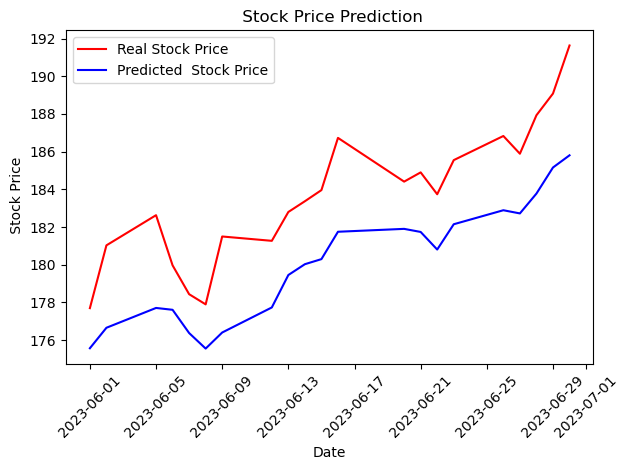

In [40]:
plt.plot(df_dates, original, color = 'red', label = 'Real Stock Price')
plt.plot(df_dates, pred, color = 'blue', label = 'Predicted  Stock Price')
plt.title(' Stock Price Prediction')
plt.xlabel('Date')
plt.ylabel(' Stock Price')
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()
plt.show()

In [41]:
df_30_days_past=df.iloc[-30:,:]

In [42]:
df_30_days_past

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2023-05-18,173.000000,175.240005,172.580002,175.050003,175.050003,65496700
2023-05-19,176.389999,176.389999,174.940002,175.160004,175.160004,55772400
2023-05-22,173.979996,174.710007,173.449997,174.199997,174.199997,43570900
2023-05-23,173.130005,173.380005,171.279999,171.559998,171.559998,50747300
2023-05-24,171.089996,172.419998,170.520004,171.839996,171.839996,45143500
2023-05-25,172.410004,173.899994,171.690002,172.990005,172.990005,56058300
2023-05-26,173.320007,175.770004,173.110001,175.429993,175.429993,54835000
2023-05-30,176.960007,178.990005,176.570007,177.300003,177.300003,55964400
2023-05-31,177.330002,179.350006,176.759995,177.250000,177.250000,99625300


In [43]:
df_30_days_future=pd.read_csv("test.csv",parse_dates=["Date"],index_col=[0])
df_30_days_future.shape

FileNotFoundError: [Errno 2] No such file or directory: 'test.csv'

In [44]:
df_30_days_future

NameError: name 'df_30_days_future' is not defined

In [45]:
df_30_days_future["Open"]=0
df_30_days_future=df_30_days_future[["Open","High","Low","Close","Adj Close"]]
old_scaled_array=scaler.transform(df_30_days_past)
new_scaled_array=scaler.transform(df_30_days_future)
old_scaled_df=pd.DataFrame(old_scaled_array)
new_scaled_df=pd.DataFrame(new_scaled_array)

new_scaled_df.iloc[:,0]=np.nan
full_df=pd.concat([old_scaled_df,new_scaled_df]).reset_index().drop(["index"],axis=1)

NameError: name 'df_30_days_future' is not defined

In [46]:
full_df.shape

NameError: name 'full_df' is not defined

In [47]:
full_df.tail()

NameError: name 'full_df' is not defined

In [48]:
full_df.shape

NameError: name 'full_df' is not defined

In [49]:
full_df_scaled_array=full_df.values

NameError: name 'full_df' is not defined

In [50]:
full_df_scaled_array.shape

NameError: name 'full_df_scaled_array' is not defined

In [51]:
all_data=[]
time_step=30
for i in range(time_step,len(full_df_scaled_array)):
    data_x=[]
    data_x.append(full_df_scaled_array[i-time_step:i,0:full_df_scaled_array.shape[1]])
    data_x=np.array(data_x)
    prediction=my_model.predict(data_x)
    all_data.append(prediction)
    full_df.iloc[i,0]=prediction

NameError: name 'full_df_scaled_array' is not defined

In [52]:
all_data

[]

In [53]:
new_array=np.array(all_data)
#new_array=new_array.reshape(-1,1)
prediction_copies_array = np.repeat(new_array, 5, axis=-1)
y_pred_future_30_days = scaler.inverse_transform(np.reshape(prediction_copies_array,(len(new_array),5)))[:,0]

ValueError: Found array with 0 sample(s) (shape=(0, 5)) while a minimum of 1 is required.

In [54]:
y_pred_future_30_days

NameError: name 'y_pred_future_30_days' is not defined

In [55]:
from tensorflow.keras.models import Model
from tensorflow.keras.models import load_model

In [56]:
my_model.save('Model_future_value.h5')
print('Model Saved!')

Model Saved!


In [57]:
scaler

MinMaxScaler()

In [58]:
import pickle
scalerfile = 'scaler_model_future_value.pkl'
pickle.dump(scaler, open(scalerfile, 'wb'))

# END!!!!